In [ ]:
import os
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

dataset_path = Path("/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/dataset")
rf_checkpoint_path = Path("/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/models/rf_checkpoint_best_ema.pth")

Roboflow Test

In [ ]:
!pip install git+https://github.com/roboflow/rf-detr
from rfdetr import RFDETRSmall

  Cloning https://github.com/roboflow/rf-detr to /tmp/pip-req-build-lerhg3g_
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/rf-detr /tmp/pip-req-build-lerhg3g_
  Resolved https://github.com/roboflow/rf-detr to commit f6a0ae0f86579b712615f2614cd0ec769e28b084
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

In [ ]:
rf_model = RFDETRSmall(pretrain_weights="/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/models/rf_checkpoint_best_ema.pth")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 2 classes


In [ ]:
import supervision as sv

# Prep test dataset for evaluating

coco_path = "/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/Coco_dataset/"
coco_test_ds= sv.DetectionDataset.from_coco(
    images_directory_path=f"{coco_path}/test",
    annotations_path=f"{coco_path}/test/_annotations.coco.json",
)

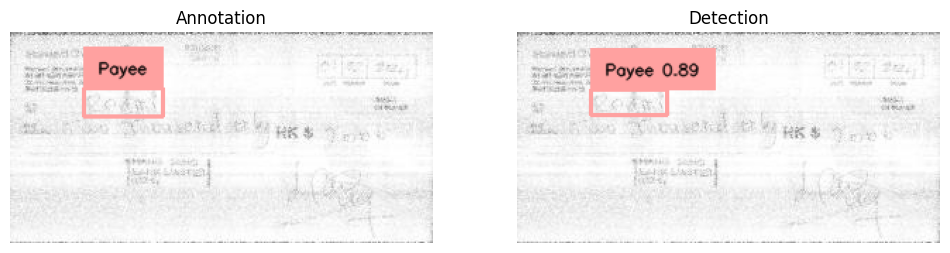

In [ ]:
from PIL import Image

path, image, annotations = coco_test_ds[0]
image = Image.open(path)

detections = rf_model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size) * 2.5
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True)

annotations_labels = [
    f"{coco_test_ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{coco_test_ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

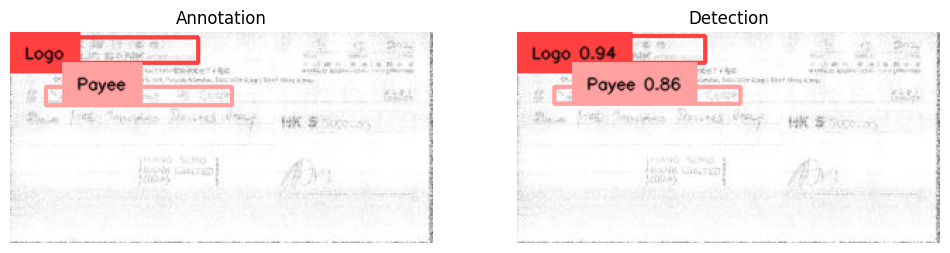

In [ ]:
import random

# Randomly select a sample from the dataset
random_index = random.randint(0, len(coco_test_ds) - 1)
path, image, annotations = coco_test_ds[random_index]

# Open image
image = Image.open(path)

# Run prediction
detections = rf_model.predict(image, threshold=0.5)

# Calculate drawing parameters
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size) * 2.5
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

# Initialize annotators
bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

# Prepare labels for annotation
annotations_labels = [
    f"{coco_test_ds.classes[class_id]}"
    for class_id in annotations.class_id
]

detections_labels = [
    f"{coco_test_ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# Annotate original image
annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

# Annotate detection result
detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

# Display side by side
sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Annotation", "Detection"]
)

Performance with IoU Function

In [ ]:
def compute_iou(box1, box2):
    # box = [xmin, ymin, xmax, ymax]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

In [ ]:
class_names = coco_test_ds.classes  # e.g., ['logo', 'payee', 'others']
print(class_names)
class_ids = list(range(len(class_names)))

['paper-checks', 'Logo', 'Payee']


Classification Report:
               precision    recall  f1-score   support

paper-checks      0.000     0.000     0.000         0
        Logo      1.000     1.000     1.000       510
       Payee      1.000     1.000     1.000       373

    accuracy                          1.000       883
   macro avg      0.667     0.667     0.667       883
weighted avg      1.000     1.000     1.000       883



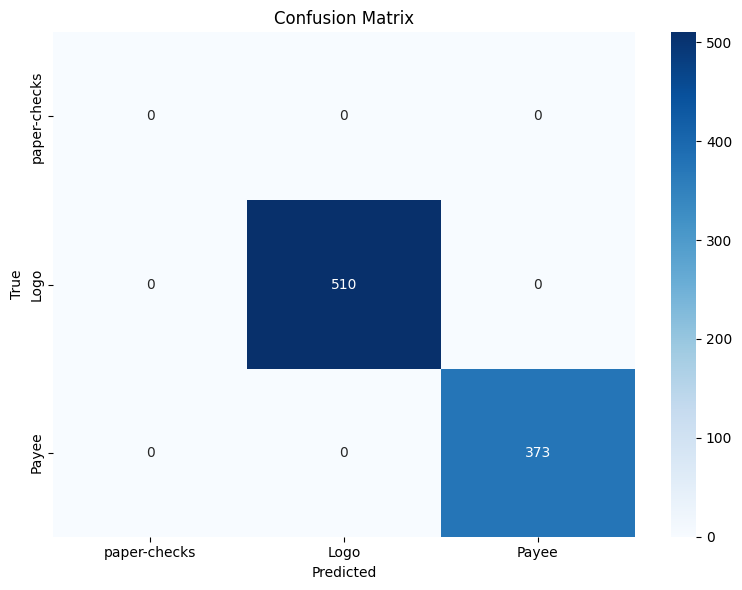

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Lists to store matched labels
y_true = []
y_pred = []

iou_threshold = 0.5  # IoU threshold for a valid match

for i in range(len(coco_test_ds)):
    path, _, annotations = coco_test_ds[i]
    image = Image.open(path)

    detections = rf_model.predict(image, threshold=0.5)

    gt_boxes = annotations.xyxy  # shape (N, 4) format: [xmin, ymin, xmax, ymax]
    gt_classes = annotations.class_id

    pred_boxes = detections.xyxy
    pred_classes = detections.class_id

    matched_gt = set()

    for pred_idx, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue  # Skip already matched GT boxes

            iou = compute_iou(pred_box, gt_box)

            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_threshold:
            matched_gt.add(best_gt_idx)
            y_true.append(gt_classes[best_gt_idx])
            y_pred.append(pred_classes[pred_idx])
        # else: it's a false positive (optional to log or handle)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get class names
class_names = coco_test_ds.classes

# Classification report
report = classification_report(
    y_true, y_pred,
    labels=class_ids,
    target_names=class_names,
    digits=3,
    zero_division=0) # avoid divide-by-zero errors for unused classes
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=class_ids)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Above shows low results in macro average due to the lack of scores from paper-checks for each metric. Hence to improve this, the evaluation will exclude this particular class, focusing only in logo and payee.

In [ ]:
# Exclude 'paper-checks' which is at index 0
excluded_class = 'paper-checks'
excluded_idx = class_names.index(excluded_class)

# Create filtered label list
filtered_class_ids = [i for i in class_ids if i != excluded_idx]
filtered_class_names = [class_names[i] for i in filtered_class_ids]
print(filtered_class_names)

['Logo', 'Payee']


Filtered Classification Report:
               precision    recall  f1-score   support

        Logo      1.000     1.000     1.000       510
       Payee      1.000     1.000     1.000       373

    accuracy                          1.000       883
   macro avg      1.000     1.000     1.000       883
weighted avg      1.000     1.000     1.000       883



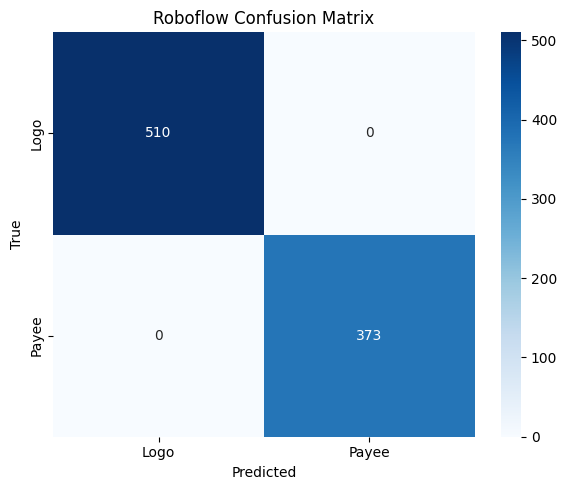

In [ ]:
report = classification_report(
    y_true, y_pred,
    labels=filtered_class_ids,
    target_names=filtered_class_names,
    digits=3,
    zero_division=0
)
print("Filtered Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=filtered_class_ids)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Roboflow Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Get classification report as dictionary
report_dict = classification_report(
    y_true,
    y_pred,
    labels=filtered_class_ids,
    target_names=filtered_class_names,
    digits=3,
    zero_division=0,
    output_dict=True
)

# Print per-class F1-scores
print("\nPer-Class F1-Scores:")
for class_name in filtered_class_names:
    f1 = report_dict[class_name]['f1-score']
    print(f"{class_name:<15} F1-Score: {f1:.4f}")

# Print overall (macro avg or weighted avg) stats
rf_macro_f1 = report_dict['macro avg']['f1-score']
rf_macro_precision = report_dict['macro avg']['precision']
rf_macro_recall = report_dict['macro avg']['recall']

print("\nMacro-Averaged Performance:")
print(f"Precision : {rf_macro_precision:.4f}")
print(f"Recall    : {rf_macro_recall:.4f}")
print(f"F1-Score  : {rf_macro_f1:.4f}")


Per-Class F1-Scores:
Logo            F1-Score: 1.0000
Payee           F1-Score: 1.0000

Macro-Averaged Performance:
Precision : 1.0000
Recall    : 1.0000
F1-Score  : 1.0000


YOLO Import

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (12002/12002), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00


In [ ]:
import torch
from ultralytics.nn.tasks import DetectionModel
from ultralytics import YOLO
torch.serialization.add_safe_globals([DetectionModel])

yl_model = torch.load('/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/models/yolo5.pt', weights_only=False)
print("Number of labels:")
print(yl_model['model'].nc)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Number of labels:
2


In [ ]:
import os

yl_label_dir = '/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/yolov8_Obb_dataset/test/labels'

for file in os.listdir(yl_label_dir):
    with open(os.path.join(yl_label_dir, file)) as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            if cls_id not in [0, 1]:
                print(f"Issue in {file}: contains invalid class ID {cls_id}")

In [ ]:
yl_model = YOLO('/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/models/yolo5.pt')
yl_metrics = yl_model.val(data='/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/yolov8_Obb_dataset/data.yaml', task='obb', plots=True, save_json=True)
print(yl_metrics)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 3.3±1.7 MB/s, size: 7.6 KB)


val: Scanning /content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/yolov8_Obb_dataset/valid/labels.cache... 565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 565/565 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [01:08<00:00,  1.91s/it]


                   all        565        913      0.985      0.992      0.991      0.878
                  Logo        515        516      0.978      0.984      0.988      0.895
                 Payee        397        397      0.992      0.999      0.995      0.861
Speed: 1.4ms preprocess, 110.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving runs/obb/val3/predictions.json...
Results saved to runs/obb/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f95254370d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0

In [ ]:
from tabulate import tabulate

yl_precision = yl_metrics.p
yl_recall = yl_metrics.r
yl_map50 = yl_metrics.map50
yl_map = yl_metrics.map

# Compute per-class F1-scores for yolov
#yl_f1_scores = 2 * (metrics.box.p * metrics.box.r) / (metrics.box.p + metrics.box.r+ 1e-16)
yl_f1_scores = 2 * (yl_precision * yl_recall) / (yl_precision + yl_recall+ 1e-16)


print("\nPer-Class F1-Scores:")
for i, name in yl_model.names.items():
    print(f"{name:<10} F1-Score: {yl_f1_scores[i]:.4f}")

# Mean F1
mean_f1_yolo = np.mean(yl_f1_scores)

comparison_data = [
    ["Precision", f"{np.mean(yl_precision):.4f}", f"{rf_macro_precision:.4f}"],
    ["Recall", f"{np.mean(yl_recall):.4f}", f"{rf_macro_recall:.4f}"],
    ["F1-Score (mean)", f"{mean_f1_yolo:.4f}", f"{rf_macro_f1:.4f}"],
    ["mAP@0.5", f"{np.mean(yl_map50):.4f}", "N/A"],
    ["mAP@0.5:0.95", f"{np.mean(yl_map):.4f}", "N/A"],
]


Per-Class F1-Scores:
Logo       F1-Score: 0.9813
Payee      F1-Score: 0.9959


In [ ]:
yolov5_metrics = {
    "Precision": np.mean(yl_precision),
    "Recall": np.mean(yl_recall),
    "F1-Score": np.mean(yl_f1_scores)
}
roboflow_metrics = {
    "Precision": rf_macro_precision,
    "Recall": rf_macro_recall,
    "F1-Score": rf_macro_f1
}

In [ ]:
metrics = list(yolov5_metrics.keys())
yolov5_vals = list(yolov5_metrics.values())
roboflow_vals = list(roboflow_metrics.values())

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, yolov5_vals, width, label='YOLOv5', color='skyblue')
bars2 = ax.bar(x + width/2, roboflow_vals, width, label='Roboflow', color='lightgreen')

# Add text labels above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

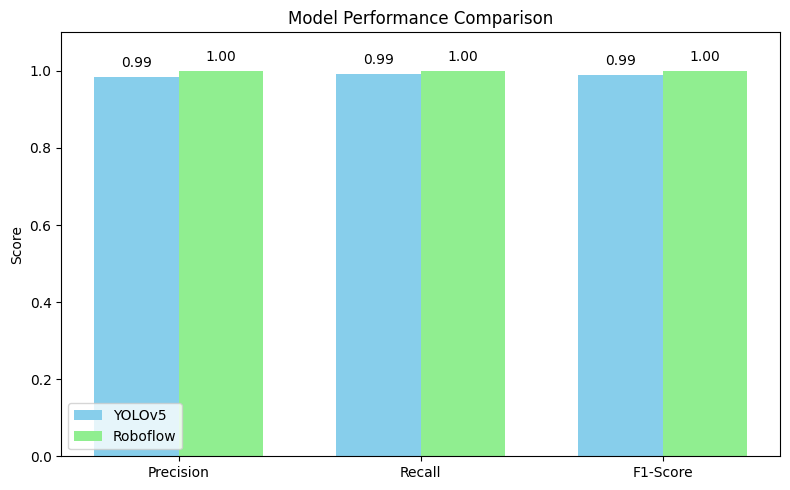

In [ ]:
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(tabulate(comparison_data, headers=["Metric", "YOLO", "Roboflow"]))

Metric             YOLO  Roboflow
---------------  ------  ----------
Precision        0.9853  1.0000
Recall           0.9919  1.0000
F1-Score (mean)  0.9886  1.0000
mAP@0.5          0.9911  N/A
mAP@0.5:0.95     0.878   N/A


using a test dataset with 5 samples, see how each model performs through average confidence in detected labels

Use coco test dataset because but yolo and roboflow have yet seen the same test sets

In [ ]:
# Path setup
test_images_path = "/content/drive/MyDrive/HTC - Software Dev and AI Bootcamp/ObjectDetectionCompare/test_dataset/images"
all_image_files = os.listdir(test_images_path)
image_filenames = [f for f in all_image_files if f.lower().endswith((".jpg", ".png", ".jpeg"))]
class_names = ['logo', 'payee']  # Manually define for both models

In [ ]:
from supervision import Color

label_color_map = {
    "logo": Color.BLUE,
    "payee": Color.GREEN
}
def get_color_for_label(label: str) -> Color:
    base_label = label.split()[0]  # Extract "logo" from "logo 0.98"
    return label_color_map.get(base_label, Color.WHITE)


0: 320x640 1 Logo, 1 Payee, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


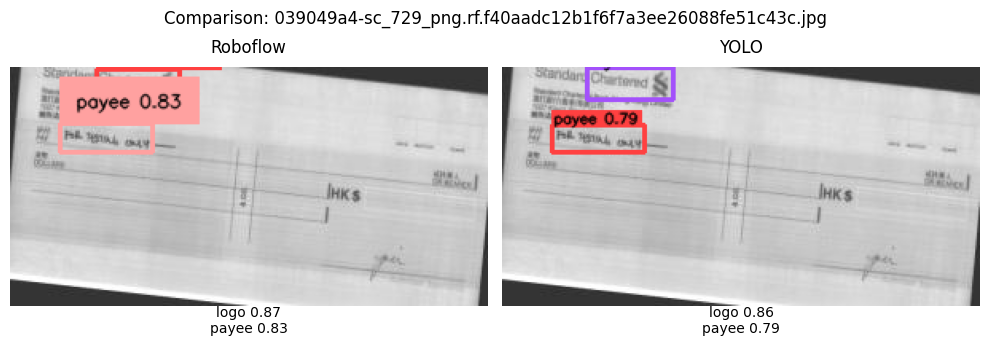


0: 320x640 1 Logo, 1 Payee, 79.2ms
Speed: 1.6ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


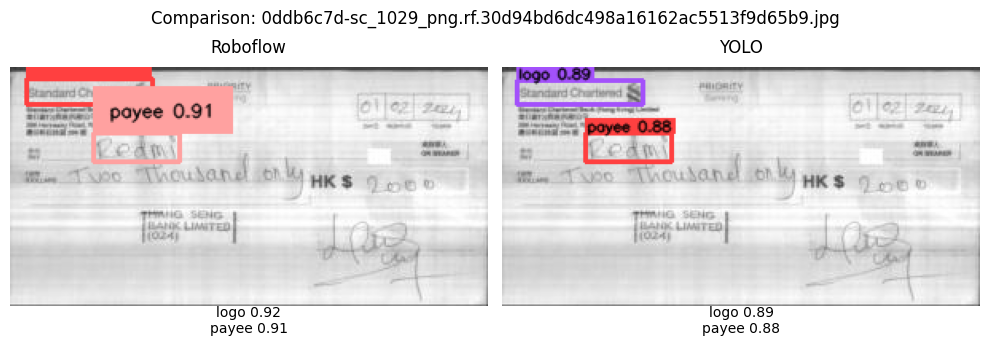


0: 320x640 1 Logo, 109.2ms
Speed: 1.8ms preprocess, 109.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


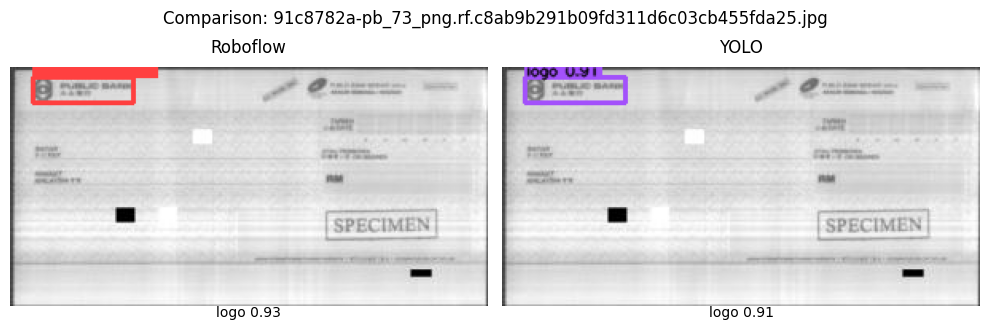


0: 320x640 1 Logo, 1 Payee, 83.0ms
Speed: 2.5ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


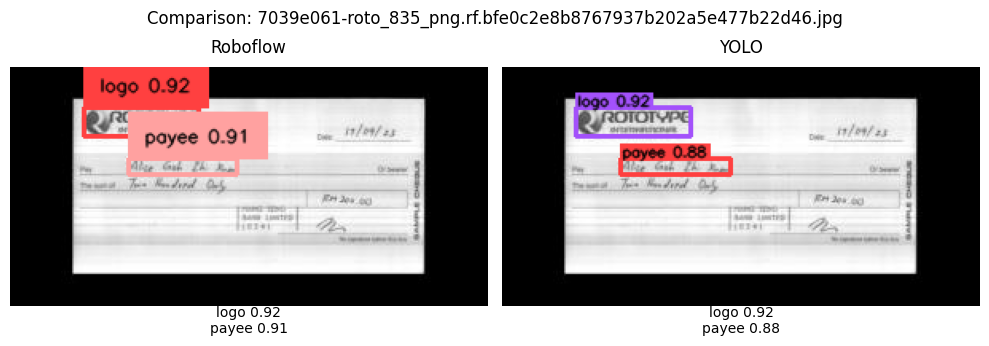


0: 320x640 1 Logo, 83.2ms
Speed: 1.6ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


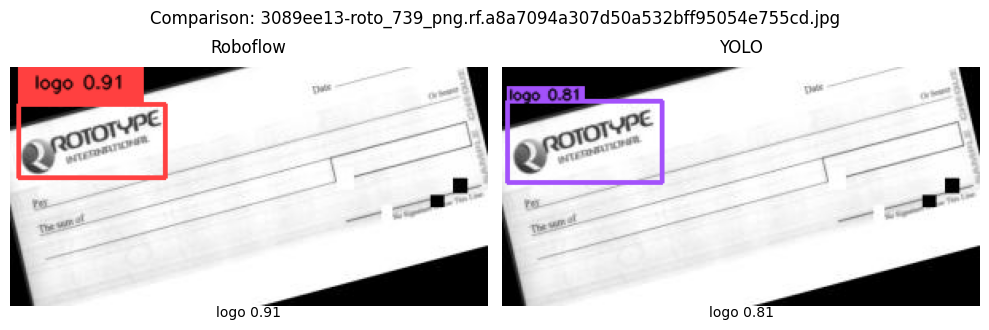

In [ ]:
# Randomly select 5 images
sample_images = random.sample(image_filenames, 5)

# Loop through selected images
for image_file in sample_images:
    image_path = os.path.join(test_images_path, image_file)
    image = Image.open(image_path).convert("RGB")

    # Roboflow detection
    rf_detections = rf_model.predict(image, threshold=0.5)
    rf_class_names = ["paper-checks", "logo", "payee"]

    rf_labels = [
        f"{rf_class_names[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(rf_detections.class_id, rf_detections.confidence)
        if class_id < len(rf_class_names)
    ]

    # Also filter boxes and scores accordingly
    valid_indices = [i for i, class_id in enumerate(rf_detections.class_id) if class_id < len(rf_class_names)]
    rf_detections = rf_detections[valid_indices]

    # Visualize Roboflow detection
    rf_image = image.copy()
    thickness = sv.calculate_optimal_line_thickness(image.size)
    text_scale = sv.calculate_optimal_text_scale(image.size) * 2.5
    rf_image = sv.BoxAnnotator(thickness=thickness).annotate(rf_image, rf_detections)
    rf_image = sv.LabelAnnotator(text_scale=text_scale, text_color=sv.Color.BLACK).annotate(rf_image, rf_detections, rf_labels)

    #Yolo Prediction
    yolo_results = yl_model(image, imgsz=640, conf=0.5)[0]

    # Extract detections
    boxes = yolo_results.boxes
    if boxes is not None and boxes.xyxy is not None and len(boxes) > 0:
        # Convert to numpy arrays
        xyxy = boxes.xyxy.cpu().numpy()
        confidence = boxes.conf.cpu().numpy()
        class_id = boxes.cls.cpu().numpy().astype(int)

        # Get class names (e.g., "payee", "logo")
        yolo_labels = [
            f"{class_names[c]} {conf:.2f}"
            for c, conf in zip(class_id, confidence)
        ]

        # Build Supervision Detections
        yolo_detections = sv.Detections(
            xyxy=xyxy,
            confidence=confidence,
            class_id=class_id
        )
    else:
        yolo_detections = sv.Detections.empty()
        yolo_labels = []

    # Visualize YOLO detection
    yolo_image = image.copy()
    yolo_image = sv.BoxAnnotator(thickness=2).annotate(yolo_image, yolo_detections)
    yolo_image = sv.LabelAnnotator(text_scale=0.3, text_color=sv.Color.BLACK, text_padding=1).annotate(yolo_image, yolo_detections, yolo_labels)

    # display side by side
    fig, axs = plt.subplots(1, 2, figsize=(10,8))

    ##roboflow image
    axs[0].imshow(rf_image)
    axs[0].axis('off')
    axs[0].set_title("Roboflow", pad=10)
    rf_label_text = "\n".join(rf_labels)
    axs[0].text(0.5, 0, rf_label_text,
            transform=axs[0].transAxes,
            ha='center', va='top',
            fontsize=10)

    ##yolo image
    axs[1].imshow(yolo_image)
    axs[1].axis('off')
    axs[1].set_title("YOLO", pad=10)
    yolo_label_text = "\n".join(yolo_labels)
    axs[1].text(0.5, 0, yolo_label_text,
            transform=axs[1].transAxes,
            ha='center', va='top',
            fontsize=10)

    plt.suptitle(f"Comparison: {image_file}", y=0.70)
    plt.subplots_adjust(top=1.5)
    plt.tight_layout()
    plt.show()